In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('seaborn-talk')
import numpy as np
import pandas as pd
from scipy.fftpack import fft
import glob
from scipy import signal

In [23]:
source = r"/Users/Mahad/Downloads/drive-download-20200317T004709Z-001/Centroids_Relevant"
outpath = r"/Users/Mahad/Downloads/drive-download-20200317T004709Z-001/Centroid_Filtered"
figpath = r"/Users/Mahad/Downloads/drive-download-20200317T004709Z-001/Figures"

In [4]:
def gaussian(x,y):
    gauss = signal.gaussian(10,3)
    x_gauss = signal.convolve(x, gauss, mode='same', method = 'direct') / gauss.sum()
    y_gauss = signal.convolve(y, gauss, mode = 'same', method = 'direct') / gauss.sum()
    return(x_gauss, y_gauss)

In [5]:
def Tortuosity(x, time):
    
    
    t = time/100
    
    Nx = len(x)  #number of points
    Nt = Nx
    Time = t[-1]-t[0]   #total sample time (in seconds)c
    fs = Nx/Time   # sample frequency
    TT = 1/fs  #delta t.
 
    meanx = np.mean(x)
    
    # . fftxvel is complex with real and imaginary part.
    #Nyquist spacing (first half of Fourier) -- the list of frequencies for which we have Fourier coefficients
    fftx = fft(x-meanx)    # this is the Fourier tranform of the x velocity
    xf = np.linspace(0.0, 1.0/(2.0*TT), Nx//2)  

    
    return xf, Nx, fftx

In [6]:
csv_list = glob.glob(source + "//*.csv")
print(len(csv_list))

79


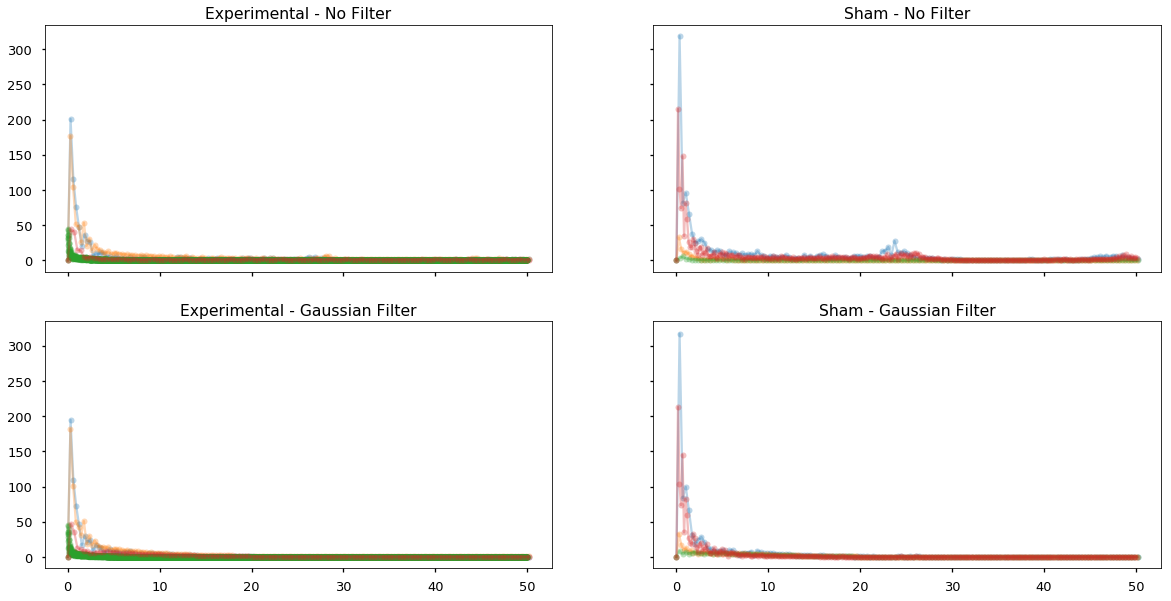

In [35]:
# name_list = []
# xf_list = []
# Nx_list = []
# fft_Cxvel_list = []
# stdxv_list = []
# meanxv_list = []
# turb_intens_list = []
# conditioned_xvel_list = []
# xvel = []
# yvel = []
# t = []
# window = []
# visit_number_list = []
f, ax = plt.subplots(2,2, figsize = (20,10), sharex = True, sharey = True)

for element in csv_list[:8]:
    df = pd.read_csv(element)
    x, y, time = df.X_position.values, df.Y_position.values, df.FrameNumber.values
    
    
    visit_number = df.VisitNumber[0]
    
    xf, Nx, fftx = Tortuosity(x, time)
    yf, Ny, ffty = Tortuosity(y, time)

    name_list.append(element[78:-4])
    
#     xf_list.append(xf)
#     Nx_list.append(Nx)
#     fft_Cxvel_list.append(fft_Cxvel)
#     stdxv_list.append(stdxv)
#     meanxv_list.append(meanxv)
#     turb_intens_list.append(turb_intens)
#     conditioned_xvel_list.append(conditioned_xvel)
#     visit_number_list.append(visit_number)
    if element[78:].startswith("Experimental"):
        
    
        sum_xy = (2.0/Ny * np.abs(ffty[0:Ny//2]) + 2.0/Nx * np.abs(fftx[0:Nx//2]))
        ax[0,0].plot(yf, sum_xy, "-o", ms = 6, alpha = 0.3)
        ax[0,0].set_title("Experimental - No Filter")
        
        
        x_gauss, y_gauss = gaussian(x,y)
        xf, Nx, fftx = Tortuosity(x_gauss, time)
        yf, Ny, ffty = Tortuosity(y_gauss, time)
        sum_xy = (2.0/Ny * np.abs(ffty[0:Ny//2]) + 2.0/Nx * np.abs(fftx[0:Nx//2]))
        ax[1,0].plot(yf, sum_xy, "-o", ms = 6, alpha = 0.3)
        ax[1,0].set_title("Experimental - Gaussian Filter")
    
    if element[78:].startswith("Sham"):
    
        sum_xy = (2.0/Ny * np.abs(ffty[0:Ny//2]) + 2.0/Nx * np.abs(fftx[0:Nx//2]))
        ax[0,1].plot(yf, sum_xy, "-o", ms = 6, alpha = 0.3)
        ax[0,1].set_title("Sham - No Filter")
        
        x_gauss, y_gauss = gaussian(x,y)
        xf, Nx, fftx = Tortuosity(x_gauss, time)
        yf, Ny, ffty = Tortuosity(y_gauss, time)
        sum_xy = (2.0/Ny * np.abs(ffty[0:Ny//2]) + 2.0/Nx * np.abs(fftx[0:Nx//2]))
        ax[1,1].plot(yf, sum_xy, "-o", ms = 6, alpha = 0.3)
        ax[1,1].set_title("Sham - Gaussian Filter")
    

plt.savefig(figpath + '//Summated_first8FFTs.png')
plt.show()   

In [14]:
name_list_ = []
for name in name_list:
    if name.startswith('L0.1_c-3_m'):
        name = name[:12]
        if name.endswith('_'):
            name = name[:-1]
        
    elif name.startswith('Sham'):
        name = name[:7]
        if name.endswith('_'):
            name = name[:-1]
    elif name.startswith('Experimental'):
        name = name[:15]
        if name.endswith('_'):
            name = name[:-1]
    
    name_list_.append(name)
#     print(name)
name_list = name_list_
name_list

['Experimental_1',
 'Experimental_1',
 'Experimental_1',
 'Experimental_2',
 'Experimental_3',
 'Experimental_4',
 'Experimental_4',
 'Experimental_5',
 'Experimental_7',
 'Experimental_7',
 'Experimental_7',
 'Experimental_7',
 'Sham_10',
 'Sham_11',
 'Sham_14',
 'Sham_14',
 'Sham_15',
 'Sham_16',
 'Sham_17',
 'Sham_1',
 'Sham_1',
 'Sham_1',
 'Sham_1',
 'Sham_1',
 'Sham_2',
 'Sham_2',
 'Sham_3',
 'Sham_3',
 'Sham_3',
 'Sham_4',
 'Sham_4',
 'Sham_4',
 'Sham_6',
 'Sham_6',
 'Sham_6',
 'Sham_6',
 'Sham_6',
 'Sham_7',
 'Sham_7',
 'Sham_7',
 'Sham_7',
 'Sham_7',
 'Sham_7',
 'Sham_7']

In [15]:
len(name_list), len(Nx_list), len(name_list), len(stdxv_list), len(meanyv_list), len(turb_intens_list)

(44, 44, 44, 44, 44, 44)

In [16]:
condition = ["Experimental"]*12
condition.extend(["Sham"]*32)
new_df = (pd.DataFrame({'name' : name_list, 'Nx' : Nx_list,
                            'stdxv': stdxv_list, 'meanxv' : meanxv_list
                       ,'turb_intens' : turb_intens_list, 'condition': condition, 'visit_number': visit_number_list}))
other_df = (pd.DataFrame({'xf' : xf_list, 'fft_Cxvel': fft_Cxvel_list, 'filterd_xvel' : conditioned_xvel_list}))



In [17]:
new_y_df = (pd.DataFrame({'name' : name_list, 'Ny' : Ny_list,
                            'stdyv': stdyv_list, 'meanyv' : meanyv_list
                       ,'turb_intens' : turb_y_intens_list, 'condition': condition, 'visit_number': visit_number_ylist}))
other_y_df = (pd.DataFrame({'yf' : yf_list, 'fft_Cyvel': fft_Cyvel_list, 'filterd_yvel' : conditioned_yvel_list}))

In [18]:
new_df.to_csv(r"C:\Users\Daniellab\Desktop\Jorge_Analysis\Tortuosity\bad_videos_removed" + r"\Tortuosity_Single_removed.csv")
other_df.to_csv(r"C:\Users\Daniellab\Desktop\Jorge_Analysis\Tortuosity\bad_videos_removed" + r"\tortuosity_Longer.csv")

In [19]:
new_y_df.to_csv(r"C:\Users\Daniellab\Desktop\Jorge_Analysis\Tortuosity\bad_videos_removed" + r"\Tortuosity_y_Single_removed.csv")
other_y_df.to_csv(r"C:\Users\Daniellab\Desktop\Jorge_Analysis\Tortuosity\bad_videos_removed" + r"\tortuosity_y_Longer.csv")

In [20]:
df = pd.read_csv(outpath + "\Tortuosity_Single.csv")

name_list = df.name


name_list

0     Experimental_1
1     Experimental_1
2     Experimental_1
3     Experimental_2
4     Experimental_2
5     Experimental_3
6     Experimental_4
7     Experimental_4
8     Experimental_5
9     Experimental_5
10    Experimental_7
11    Experimental_7
12    Experimental_7
13    Experimental_7
14           Sham_10
15           Sham_11
16           Sham_11
17           Sham_14
18           Sham_14
19           Sham_15
20           Sham_15
21           Sham_15
22           Sham_15
23           Sham_15
24           Sham_16
25           Sham_16
26           Sham_17
27           Sham_18
28            Sham_1
29            Sham_1
30            Sham_1
31            Sham_1
32            Sham_1
33            Sham_1
34            Sham_1
35            Sham_2
36            Sham_2
37            Sham_2
38            Sham_3
39            Sham_3
40            Sham_3
41            Sham_4
42            Sham_4
43            Sham_4
44            Sham_6
45            Sham_6
46            Sham_6
47           

In [21]:
df_y = pd.read_csv(outpath + "\Tortuosity_y_Single.csv")


name_y_list = df_y.name

print(len(name_y_list))

57
